In [13]:
from PIL import Image
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, END
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    GoogleGenerativeAIEmbeddings
)
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from PIL import Image
from qdrant_client import models
from langgraph.graph import StateGraph, END
import json

In [14]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_KEY = os.getenv("GEMINI_PAID_KEY")

In [15]:
gemini = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",
    temperature=0,
    api_key=GEMINI_KEY
)

In [16]:
embeddings= GoogleGenerativeAIEmbeddings(
    model= "gemini-embedding-001",
    api_key=GEMINI_KEY
)

In [17]:
qdrant= QdrantClient(
    url="http://localhost:6333"
)

In [18]:
from qdrant_client.models import PointStruct

topology_kb = [
    Document(page_content=""" 
        You are a CAD topology extraction expert.
        Analyze the PROVIDED ORIGINAL CAD IMAGE (NOT recolored).
        Output STRICT JSON inside markers. No explanation.

        <<topoloty starts>>

        {{
        "views": [
            {{
            "view": "front",
            "outer_closed_loops": [
                {{
                "loop_id": 1,
                "region": "MATERIAL",
                "nodes": <count>,
                "edges": {{
                    "total_edges": <count>,
                    "edge_type_counts": {{"straight": X, "curved": Y, "fillet": Z, "chamfer": W}},
                    "edge_1": {{
                    "type": "...", 
                    "dimension": "...", 
                    "source": "extracted|calculated|null",
                    "note": "optional: how value was obtained"
                    }},
                    ...
                }},
                "perimeter": "value_mm",
                "perimeter_calculation": "edge_1(value,source) + edge_2(value,source) + ... = total"
                }}
            ],
            "inner_closed_loops": [
                {{
                "loop_id": N,
                "region": "VOID",
                "type": "Circle|Circle Pattern|...",
                "position": {{
                    "x": "...", 
                    "y": "...",
                    "source": "extracted|calculated|null",
                    "note": "optional: from which dimension line"
                }} OR 
                "positions": [
                    {{
                    "x": "...", 
                    "y": "...",
                    "source": "extracted|calculated|symmetry",
                    "note": "optional"
                    }}, 
                    ...
                ],
                "edges": {{
                    "total_edges": 0 or count,
                    "edge_type_counts": {{...}},
                    "edge_1": {{
                    "type": "circle", 
                    "dimension": "ØXmm", 
                    "circumference": "π×d",
                    "source": "extracted|calculated"
                    }},
                    ...
                }},
                "total_circumference_or_perimeter": "value_mm",
                "note": "optional"
                }},
                ... (repeat for EVERY circle/hole)
            ],
            "total_edge_length_summary": {{
                "outer_loop_perimeter": "value_mm",
                "inner_loops_total": "value_mm",
                "grand_total": "value_mm"
            }}
            }}
        ]
        }}
        """),

    # FUNDAMENTAL RULES
    Document(page_content="Inner loops are always VOID. Outer loops are always MATERIAL."),
    Document(page_content="Edge structure: Each edge MUST have 'type' and 'dimension'. Total_edges MUST be specified."),
    Document(page_content="Edge type counts must sum to total_edges. Format: {'straight': X, 'curved': Y, 'fillet': Z, 'chamfer': W}"),
    
    # SPECIAL CASES: CIRCLES & CONCENTRIC PATTERNS
    Document(page_content="Circle entities: nodes=0, edges=0, only mention type='circle'."),
    Document(page_content="Concentric circles inside outer loop: count as ONE inner loop with type='concentric_circles'. Only the innermost circle is VOID; outer concentric rings are MATERIAL."),
    
    # EDGE TYPE DEFINITIONS
    Document(page_content="Edge type 'straight': Linear edges, includes chamfers if noted."),
    Document(page_content="Edge type 'curved': Arc/semicircle cuts (e.g., R5.0 slots)."),
    Document(page_content="Edge type 'fillet': Small rounded corners (typically R1.5mm or smaller, ≤90° arcs)."),
    Document(page_content="Edge type 'chamfer': Angled straight edge cutting a corner. Separate from 'straight' in counts."),
    
    # GEOMETRY PATTERNS
    Document(page_content="Rectangle → 4 nodes, 4 straight edges."),
    Document(page_content="Fillet corners → reduce node count, add fillet edges (e.g., 4 fillets on rectangle = 4 nodes, 4 straight + 4 fillet edges)."),
    
    # DIMENSION EXTRACTION RULES (PRIORITY ORDER)
    Document(page_content="PRIORITY 1: Extract explicit dimensions from dimension lines FIRST. Never calculate what's already labeled (e.g., if 70.00 and 50.00 are shown, use those exact values)."),
    Document(page_content="PRIORITY 2: Calculate from overall dimensions (e.g., rectangle width=70mm → top/bottom edges=70mm)."),
    Document(page_content="PRIORITY 3: Use null (without quotes) ONLY for unmeasurable values (unmeasured chamfers/fillets, segments without references)."),
    Document(page_content="For segmented edges split by cutouts: look for individual segment dimensions."),
    Document(page_content="Verify calculated values match visible proportions. Re-check for missed dimension callouts if results seem wrong."),
    Document(page_content="NEVER use 'variable', 'unknown', or 'N/A' for dimensions. Calculate, estimate from proportions, or use null."),
      
    # CHAMFER HANDLING
    Document(page_content="Chamfer dimensions: If shown (C2, 2×45°), use that value. If chamfer exists but unmeasured, use null."),
    Document(page_content="Chamfers are SEPARATE from straight edges in edge_type_counts."),
    
    # PERIMETER & LENGTH CALCULATIONS
    Document(page_content="Circle circumference: C = π × diameter. Example: Ø3.18mm → 9.99mm."),
    Document(page_content="Circle patterns (e.g., 6X Ø3.18mm): calculate one instance circumference, note total in total_circumference_or_perimeter."),
    Document(page_content="Rectangle/polygon perimeter: sum all edge lengths (skip null edges)."),
    Document(page_content="Fillet arc length (90°): ≈ (π/2) × radius. Example: R1.5mm → 2.36mm."),
    Document(page_content="Slot perimeter: straight sections + curved ends. R5.0mm semicircle arc = π × radius = 15.71mm."),
    Document(page_content="Include total_edge_length_summary at end of each view with outer_loop_perimeter, inner_loops_total, and grand_total."),
    
    # POSITION & COORDINATE SYSTEM
    Document(page_content="Origin (0,0) is bottom-left corner of outer loop. X-axis→right, Y-axis→up."),
    Document(page_content="Feature positions refer to CENTER POINT (x, y). Extract from dimension lines."),
    Document(page_content="Position calculation: x = total_width - dimension_from_right. y = total_height - dimension_from_top."),
    Document(page_content="Single features: use 'position' object {x, y, reference}. Patterns: use 'positions' array with each instance's coordinates."),
    Document(page_content="Extract position dimensions like '27.8' from left, '13.7' from right, '8.5' from top to locate feature centers.")
]
#Create qdrant collection
qdrant.recreate_collection(
    collection_name="2D_costEstimation_topology_rules",
    vectors_config={
        "size": 3072,
        "distance": "Cosine"
    }
)

points = []

for idx, doc in enumerate(topology_kb):
    vector = embeddings.embed_query(doc.page_content)
    
    points.append(
        PointStruct(
            id=idx,
            vector=vector,
            payload={"text": doc.page_content}
        )
    )

#Upload documents as points with embeddings
qdrant.upload_points(
    collection_name="2D_costEstimation_topology_rules",
    points=points
)

print("Topology knowledge base updated in Qdrant RAG.")

/var/folders/wl/8x04_m0j1rl9z6rkvjyrqvkc0000gn/T/ipykernel_8490/1710028205.py:128: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


Topology knowledge base updated in Qdrant RAG.


In [19]:
class CADState (TypedDict):
    image_path: str
    visual_features: Optional[str]
    decision: Optional[str]
    retrieved_rules: Optional[List[str]]
    topology_output: Optional[str]

In [20]:
import base64
import mimetypes

def extract_features(state: CADState):
    image_path = state["image_path"]
    
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
    
    mime_type, _ = mimetypes.guess_type(image_path)
    data_uri = f"data:{mime_type or 'image/png'};base64,{base64_image}"

    # Enhanced prompt to extract positions
    response = gemini.invoke([
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    "CRITICAL: Examine this CAD drawing VERY CAREFULLY and extract:\n\n"
                    "1. COUNT ALL CIRCLES/HOLES - Don't miss any!\n"
                    "   - Count EVERY single circle visible\n"
                    "   - Look for patterns (e.g., '6X Ø3.18' means 6 circles)\n"
                    "   - Different sizes may indicate different feature groups\n"
                    "   - TOTAL COUNT is very important!\n\n"
                    "2. ALL DIMENSIONS:\n"
                    "   - Overall dimensions (width, height)\n"
                    "   - Linear dimensions between features\n"
                    "   - ALL hole diameters (Ø notation) - list EVERY different size\n"
                    "   - Radii (R notation)\n"
                    "   - Chamfer dimensions\n\n"
                    "3. POSITION DIMENSIONS for EVERY hole:\n"
                    "   - Distance from left/right edges\n"
                    "   - Distance from top/bottom edges\n"
                    "   - Spacing between holes in patterns\n"
                    "   - Center-to-center distances\n\n"
                    "4. All shapes and features:\n"
                    "   - Outer boundary shape\n"
                    "   - Chamfered/filleted corners\n"
                    "   - Curved edges or cutouts\n\n"
                    "5. Edge counts:\n"
                    "   - Straight edges\n"
                    "   - Chamfers\n"
                    "   - Fillets\n"
                    "   - Curved sections\n\n"
                    "VERIFY YOUR COUNT: How many total circles/holes do you see?\n"
                    "List them by size and quantity (e.g., '1x Ø8.0, 1x Ø4.0, 6x Ø3.18, 4x Ø2.5')\n\n"
                    "Be EXHAUSTIVE - extract EVERY dimension and locate EVERY feature!"
                )},
                {"type": "image_url", "image_url": data_uri}
            ],
        }
    ])

    content = response.content
    if isinstance(content, list):
        content = " ".join([c if isinstance(c, str) else c.get("text", "") for c in content])
    elif isinstance(content, dict):
        content = content.get("text", "")

    return {"visual_features": str(content).strip()}

In [21]:
def decide_topology(state: CADState):
    prompt = f"""
    Given the extracted visual features:
    {state['visual_features']}

    Should topology rules be applied?
    Answer ONLY "YES" or "NO".
    """

    response = gemini.invoke(prompt)
    content = response.content
    
    # 1. Handle if content is a list of parts/dicts
    if isinstance(content, list):
        content = content[0] if content else ""
        
    # 2. Handle if content is a dictionary
    if isinstance(content, dict):
        content = content.get("text", "")

    # Convert to string and clean it up
    decision_text = str(content).strip().upper()
    
    # Ensure it's strictly YES or NO to avoid logic errors
    if "YES" in decision_text:
        decision_text = "YES"
    elif "NO" in decision_text:
        decision_text = "NO"

    return {
        "decision": decision_text
    }

In [22]:
def retrieve_topology_rules(state: CADState):
    query_text = str(state["visual_features"])
    query_vector = embeddings.embed_query(query_text)

    # Use the newer .query_points() or .search() 
    hits = qdrant.query_points(
        collection_name="2D_costEstimation_topology_rules",
        query=query_vector,
        limit=5  # Increased to get more context
    ).points

    rules = [hit.payload["text"] for hit in hits]
    return {
        "retrieved_rules": rules 
    }

In [23]:
def calculate_missing_dimensions(state: CADState):
    """
    Enhance visual features with calculated dimensions for missing edges
    """
    prompt = f"""
Given this CAD drawing analysis:
{state['visual_features']}

And these topology rules:
{state.get('retrieved_rules', [])}

Your task:
1. LIST ALL features you found (especially ALL circles/holes)
2. VERIFY the count - how many circles total?
3. Extract ALL EXPLICIT dimensions from the drawing - look at every dimension line carefully
4. Calculate missing dimensions using EXACT geometry:
   
   CRITICAL DIMENSION EXTRACTION RULES:
   - If you see a dimension line with a value, EXTRACT that exact value
   - Don't calculate what's already shown - USE the shown value
   
   For each edge segment:
      1. If a dimension is shown in the drawing (dimension line, radius, diameter), use that exact value.
      2. Curved segments: extract radius or arc length directly from geometry.
      3. Only calculate a segment if its value is not explicitly shown in the drawing.
      4. Do not redistribute or approximate remaining lengths to other edges.
      5. Total perimeter must equal sum of all segment lengths (verify consistency).
      6. Each run must return identical values if the geometry and inputs are unchanged.
      7. Use null only if a segment's dimension is impossible to determine.

   
   CALCULATION ONLY when dimension NOT shown:
   - Calculate missing dimensions only if they are not explicitly shown in the image.
   - Carefully observe the image and use any given dimensions to determine missing values wherever possible.
   - For segments split by features (e.g., holes, edges, sections), extract each segment’s dimension if shown.
   - Ensure all calculated values make geometric sense and are consistent with the image.
   - Do not assume any value that cannot be determined from what is shown.
   - Provide clear steps for each calculation.


5. For EACH circle/hole, determine:
   - Diameter (extract from Ø callouts)
   - Position (extract from dimension lines)
   - Which pattern it belongs to

6. Provide values as:
   - EXACT from drawing (highest priority - look at dimension lines!)
   - CALCULATED only if not shown
   - null ONLY if truly impossible

CRITICAL: 
- Read dimension lines CAREFULLY - don't overlook any values
- Don't calculate what's already dimensioned
- If bottom edge shows two segments with dimensions, USE those exact values

Return comprehensive analysis with:
- ALL explicit dimensions found (list every dimension line value)
- Complete circle inventory
- Calculated dimensions (only for what's not shown)
- Position data for every feature
"""

In [24]:
def solve_linear_edge(total_length, parts):
    """
    total_length: float

    parts: list of dicts like:
    [
        {"name": "left_segment", "value": 10},
        {"name": "cutout_span", "value": None},
        {"name": "right_segment", "value": 5}
    ]
    """

    known_sum = sum(p["value"] for p in parts if p["value"] is not None)
    unknown_parts = [p for p in parts if p["value"] is None]

    if len(unknown_parts) == 1:
        unknown_parts[0]["value"] = total_length - known_sum

    return parts


In [25]:
def generate_topology(state: CADState):
    prompt = f"""
Using:
Visual Features (including calculated dimensions):
{state['visual_features']}

Topology Rules:
{state['retrieved_rules']}

Generate structured topological information in JSON with this EXACT structure:

{{
  "views": [
    {{
      "view": "front",
      "outer_closed_loops": [
        {{
          "loop_id": 1,
          "region": "MATERIAL",
          "nodes": <count>,
          "edges": {{
            "total_edges": <count>,
            "edge_type_counts": {{
              "straight": <count>,
              "curved": <count>,
              "fillet": <count>,
              "chamfer": <count>
            }},
            "edge_1": {{"type": "straight|curved|fillet|chamfer", "dimension": "<value_or_null>"}},
            "edge_2": {{"type": "...", "dimension": "..."}},
            ...
          }},
          "perimeter": "<sum_value>mm",
          "perimeter_calculation": "edge_values sum"
        }}
      ],
      "inner_closed_loops": [
        {{
          "loop_id": <id>,
          "region": "VOID",
          "type": "Circle|Circle Pattern|Slot|Rectangle|...",
          "position": {{"x": "value_or_null", "y": "value_or_null"}} OR
          "positions": [{{"x": "...", "y": "..."}}, ...],
          "edges": {{
            "total_edges": <count>,
            "edge_type_counts": {{
              "straight": <count>,
              "curved": <count>,
              "fillet": <count>,
              "circle": <count>
            }},
            "edge_1": {{"type": "circle|straight|...", "dimension": "...", "circumference": "..."}},
            ...
          }},
          "total_circumference_or_perimeter": "<value>mm",
          "note": "optional note for patterns"
        }}
      ],
      "total_edge_length_summary": {{
        "outer_loop_perimeter": "<value>mm",
        "inner_loops_total": "<value>mm",
        "grand_total": "<value>mm"
      }}
    }}
  ]
}}

CRITICAL RULES:
**COUNT ALL SHAPES INSIDE THE LOOP** - Create separate inner_closed_loops entry for EACH:
   - Single circles: individual entries
   - Patterns: ONE entry with "positions" array listing ALL instances
   - Don't group different-sized circles together
   - Verify total matches what's in the drawing

1. **NO DESCRIPTION FIELD** - Do not include "description" in any edge

2. **EXTRACT dimensions from drawing:**
   - Use visible dimensions exactly as shown
   - Calculate missing values when possible
   - Use null only when impossible to determine

3. **PERIMETER calculation (outer loop):**
   - Sum dimension values directly (no arc calculations)
   - straight edge: use length value
   - fillet: use radius value (R1.5mm → 1.5)
   - curved: use radius value (R5.0mm → 5.0)
   - edge_type: use value if known, else null (exclude from sum)
   
  
4. **EDGE CALCULATIONS**
  For each edge segment:

  1. If the segment is measurable in the geometry (straight or curved), use the **exact measured value**.
  2. Curved segments: extract radius or arc length directly from geometry.
  3. Calculated segments: only calculate if the exact value cannot be measured; otherwise, **do not redistribute or approximate**.
  4. For each edge segment:
    - Use exact value from drawing if available.
    - Curved edges: use extracted radius/arc length.
    - Only calculate if not explicitly dimensioned.
    - Do not redistribute remaining lengths arbitrarily.
    - Verify total perimeter matches sum of all segments.
    - Each run must return identical values if inputs and geometry are unchanged.
    - Use null only if dimension is impossible to determine.

  5. Do not allow arbitrary splitting of straight edges around curves.

5. **CIRCUMFERENCE calculation (circles):**
   - Formula: π × diameter
   - Always calculate for circles
   - Include in edge_1 for circles

6. **POSITION extraction:**
   - Origin: bottom-left corner of outer loop = (0, 0)
   - Single features: use "position": {{"x": "...", "y": "..."}}
   - Patterns: use "positions": [{{"x": "...", "y": "..."}}, ...]
   - Extract from dimension lines in drawing
   - Calculate if needed (e.g., from right edge: x = width - dimension)
   - Use null only if truly cannot determine

7. **For patterns:**
   - Calculate per-instance values
   - Multiply by count for total_circumference_or_perimeter
   - List all positions in array

8. **Edge structure:**
   - type: edge type (required)
   - dimension: value with unit or null (required)
   - circumference: only for circles (required for circles)
  
VERIFY: If drawing shows 6X Ø3.18 + 4X Ø2.5 + 1X Ø8 + 1X Ø4 = 12 circles total,
        then create entries for ALL 12 (one pattern entry for 6, one for 4, two singles)

Return ONLY valid JSON, properly formatted.
Extract ALL available information from the drawing.
"""

    response = gemini.invoke(prompt)

    content = response.content
    if isinstance(content, list):
        content = " ".join([
            c if isinstance(c, str) else c.get("text", "")
            for c in content
        ])
    elif isinstance(content, dict):
        content = content.get("text", "")

    content = content.strip()

    # Clean up JSON if wrapped in markdown
    if content.startswith("```json"):
        content = content.replace("```json", "").replace("```", "").strip()
    if content.endswith("```"):
        content = content.rstrip("`").strip()

    try:
        topology_json = json.loads(content)
        pretty_json = json.dumps(topology_json, indent=2)
    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        print(f"Raw content: {content[:500]}")
        pretty_json = content

    return {
        "topology_output": pretty_json
    }

In [26]:
def should_retrieve(state: CADState):
    return state["decision"] == "YES"

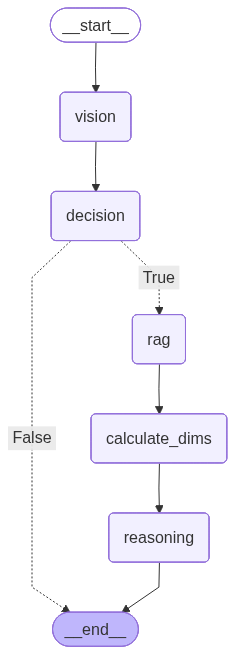

In [27]:
graph = StateGraph(CADState)

graph.add_node("vision", extract_features)
graph.add_node("decision", decide_topology)
graph.add_node("rag", retrieve_topology_rules)
graph.add_node("calculate_dims", calculate_missing_dimensions)
graph.add_node("reasoning", generate_topology)

graph.set_entry_point("vision")

graph.add_edge("vision", "decision")
graph.add_conditional_edges(
    "decision",
    should_retrieve,
    {
        True: "rag",  # Go to RAG first
        False: END
    }
)

graph.add_edge("rag", "calculate_dims")  # Then calculate dimensions
graph.add_edge("calculate_dims", "reasoning")  # Then generate topology
graph.add_edge("reasoning", END)

app = graph.compile()
app

In [29]:
result = app.invoke(
    {
        "image_path": "/Users/naswahmanandhar/Desktop/RAG/images/1.png"
    }
)

print("===== TOPOLOGY OUTPUT =====")
print(result["topology_output"])

with open("/Users/naswahmanandhar/Desktop/RAG/FullPipeline Results/1result.txt", "w") as f:
    f.write(result["topology_output"])
print("Topology JSON saved to topology_output.txt")

JSON parsing error: Expecting value: line 1 column 1 (char 0)
Raw content: <<topoloty starts>>
{
  "views": [
    {
      "view": "front",
      "outer_closed_loops": [
        {
          "loop_id": 1,
          "region": "MATERIAL",
          "nodes": 8,
          "edges": {
            "total_edges": 8,
            "edge_type_counts": {
              "straight": 4,
              "curved": 0,
              "fillet": 0,
              "chamfer": 4
            },
            "edge_1": {
              "type": "straight",
              "dimension": "296.00mm",
           
===== TOPOLOGY OUTPUT =====
<<topoloty starts>>
{
  "views": [
    {
      "view": "front",
      "outer_closed_loops": [
        {
          "loop_id": 1,
          "region": "MATERIAL",
          "nodes": 8,
          "edges": {
            "total_edges": 8,
            "edge_type_counts": {
              "straight": 4,
              "curved": 0,
              "fillet": 0,
              "chamfer": 4
            },
    